In [2]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

In [4]:
DATA_DIR = "/mnt/ernie_main/Ghassan/ephys/data/periconnectivity"
peri_fs = glob.glob(os.path.join(DATA_DIR, "*pat*.csv"))



In [5]:
print(f"loading file: {peri_fs[0]}")
tst = pd.read_csv(peri_fs[0])


loading file: /mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat02.csv


In [6]:
tst

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,eventID,patID,sz_type
0,0,soz,12.450569,12.475246,0.024678,delta,0.0_0.0_0.0,10,Epat02,FIAS
1,0,pz,-0.491526,0.979263,1.470788,delta,0.0_0.0_0.0,10,Epat02,FIAS
2,0,nz,-0.963374,0.757031,1.720405,delta,0.0_0.0_0.0,10,Epat02,FIAS
3,0,soz,13.446027,13.864328,0.418302,theta,0.0_0.0_0.0,10,Epat02,FIAS
4,0,pz,-0.634089,1.176074,1.810163,theta,0.0_0.0_0.0,10,Epat02,FIAS
...,...,...,...,...,...,...,...,...,...,...
172213,1319,pz,-1.318887,4.271698,5.590585,gamma_l,2.0_2.0_2.0,9,Epat02,FIAS
172214,1319,nz,-4.013563,1.121755,5.135318,gamma_l,2.0_2.0_2.0,9,Epat02,FIAS
172215,1319,soz,7.512351,6.781295,-0.731056,gamma_H,2.0_2.0_2.0,9,Epat02,FIAS
172216,1319,pz,-1.393412,4.900393,6.293805,gamma_H,2.0_2.0_2.0,9,Epat02,FIAS


In [4]:
grp_peri_dfs = []
check_list = []
for f in peri_fs:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    peri_df = pd.read_csv(f)
    try:
        peri_event_df = center_transitions(peri_df)
        grp_peri_dfs.append(peri_event_df)
    except:
        check_list.append(f)
grp_peri_dfs = pd.concat(grp_peri_dfs)

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['win_sz_centered'] = center_windows(event_df.window_designations, event_df.period.values)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['sz_end'] = get_sz_end(event_df)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:496: Settin

In [8]:
len(set(grp_peri_dfs.patID))

71

# Visualizing seizure-centered connectivity dynamics

In [10]:
set(peri_df.window_designations)

{'0.0_0.0_0.0',
 '0.0_0.0_1.0',
 '0.0_1.0_1.0',
 '1.0_1.0_1.0',
 '1.0_1.0_2.0',
 '1.0_2.0_2.0',
 '2.0_2.0_2.0'}

In [11]:
peri_stats_df = grp_peri_dfs[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_centered']].groupby(['patID','region','freq_band', 'win_sz_centered']).mean().reset_index()
peri_stats_df


,patID,region,freq_band,win_sz_centered,net_pdc,in_pdc,out_pdc
0,Epat02,nz,alpha,-595,-0.028535,-0.021260,0.007275
1,Epat02,nz,alpha,-594,-0.031440,-0.018799,0.012640
2,Epat02,nz,alpha,-593,-0.033993,-0.025225,0.008767
3,Epat02,nz,alpha,-592,-0.032835,-0.022032,0.010803
4,Epat02,nz,alpha,-591,-0.029620,-0.020153,0.009468
...,...,...,...,...,...,...,...
1697491,pat33,soz,theta,661,-0.287354,-0.345291,-0.057937
1697492,pat33,soz,theta,662,-0.392330,-0.371164,0.021166
1697493,pat33,soz,theta,663,-0.532871,-0.242734,0.290137
1697494,pat33,soz,theta,664,-0.181882,-0.122251,0.059631


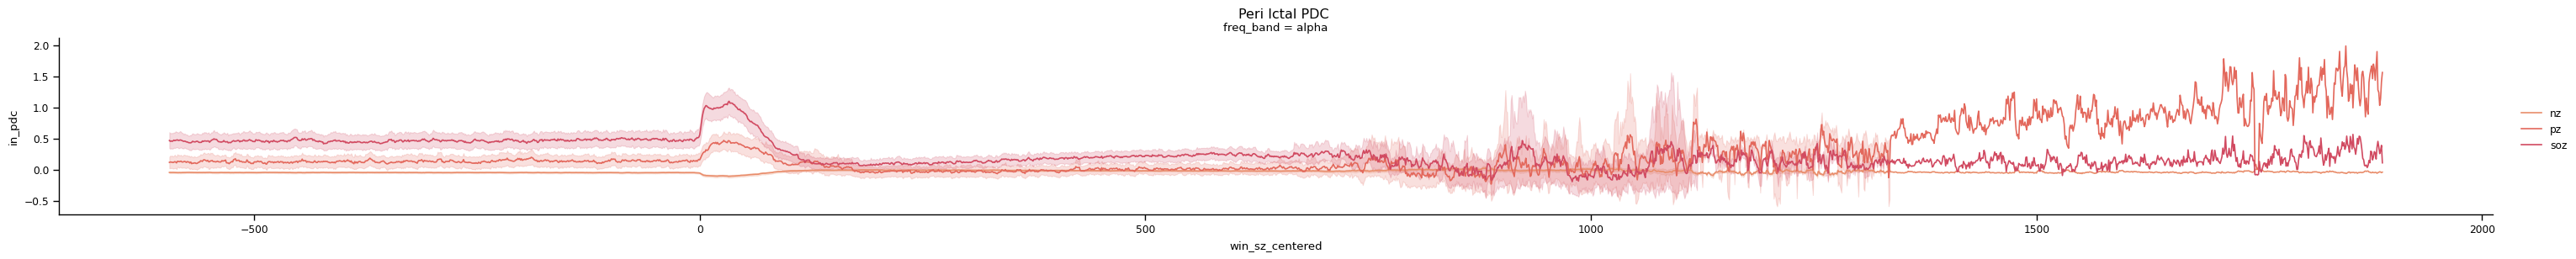

In [13]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(peri_stats_df, row='freq_band',row_order=['alpha'],aspect=10) 
        grid.map_dataframe(sns.lineplot, y='out_pdc',x='win_sz_centered', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PDC",y=1.01)
        plt.suptitle("OUTWARD")
        plt.savefig("../viz/peri_Epat_FULL_in_peri_pdc.pdf",transparent=True)


TODO:
1. Label backwards from first seizure window
1. sample 5 windows in seizure span
1. align seizure end windows
1. aggregate all subjs

In [30]:
peri_df

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,subj,sz_type
0,0,soz,-0.064993,-0.072037,-0.007044,delta,0.0_0.0_0.0,Spat52,FIAS
1,0,pz,NaN,NaN,NaN,delta,0.0_0.0_0.0,Spat52,FIAS
2,0,nz,0.004149,0.004598,0.000450,delta,0.0_0.0_0.0,Spat52,FIAS
3,0,soz,-0.093501,-0.078826,0.014675,theta,0.0_0.0_0.0,Spat52,FIAS
4,0,pz,NaN,NaN,NaN,theta,0.0_0.0_0.0,Spat52,FIAS
...,...,...,...,...,...,...,...,...,...
95845,1318,pz,-0.494625,-0.328764,0.165860,gamma_l,2.0_2.0_2.0,Spat52,FIAS
95846,1318,nz,0.041097,0.018144,-0.022953,gamma_l,2.0_2.0_2.0,Spat52,FIAS
95847,1318,soz,-0.767384,-0.233676,0.533708,gamma_H,2.0_2.0_2.0,Spat52,FIAS
95848,1318,pz,-0.635416,-0.337736,0.297680,gamma_H,2.0_2.0_2.0,Spat52,FIAS


In [35]:
tst = peri_df[peri_df.freq_band =='alpha']
tst = tst[tst.region =='soz']
tst[tst.window_designations == '0.0_1.0_1.0']

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,subj,sz_type
10770,598,soz,-0.231942,-0.178899,0.053043,alpha,0.0_1.0_1.0,Spat52,FIAS
10788,599,soz,-0.044067,-0.071976,-0.027909,alpha,0.0_1.0_1.0,Spat52,FIAS
35808,598,soz,-0.070086,-0.066473,0.003613,alpha,0.0_1.0_1.0,Spat52,FIAS
35826,599,soz,-0.023353,-0.033859,-0.010506,alpha,0.0_1.0_1.0,Spat52,FIAS
59406,598,soz,-0.110572,-0.013025,0.097547,alpha,0.0_1.0_1.0,Spat52,FAS
59424,599,soz,-1.624492,-0.066497,1.557994,alpha,0.0_1.0_1.0,Spat52,FAS
82878,598,soz,0.535177,0.378955,-0.156222,alpha,0.0_1.0_1.0,Spat52,FIAS
82896,599,soz,0.347449,0.287193,-0.060255,alpha,0.0_1.0_1.0,Spat52,FIAS


In [33]:
Counter(tst.window_designations)

Counter({'0.0_0.0_0.0': 2380,
         '2.0_2.0_2.0': 2380,
         '1.0_1.0_1.0': 525,
         '0.0_0.0_1.0': 12,
         '1.0_1.0_2.0': 12,
         '0.0_1.0_1.0': 8,
         '1.0_2.0_2.0': 8})